<a href="https://colab.research.google.com/github/GitAIwithMike/ATC-Models/blob/main/notebooks/ATC_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Clone the repository
!git clone https://github.com/GitAIwithMike/ATC-Models.git
%cd ATC-Models

# Install the required libraries
!pip install torch transformers datasets librosa pydub


Cloning into 'ATC-Models'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 117 (delta 30), reused 99 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 28.30 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (55/55), done.
Filtering content: 100% (27/27), 1.45 GiB | 42.16 MiB/s, done.
/content/ATC-Models
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully

Audio file downloaded and saved to: processed_audio.wav
Loaded processed audio file.
Original Sample Rate: 44100
Resampled Sample Rate: 16000
Duration: 850.83 seconds


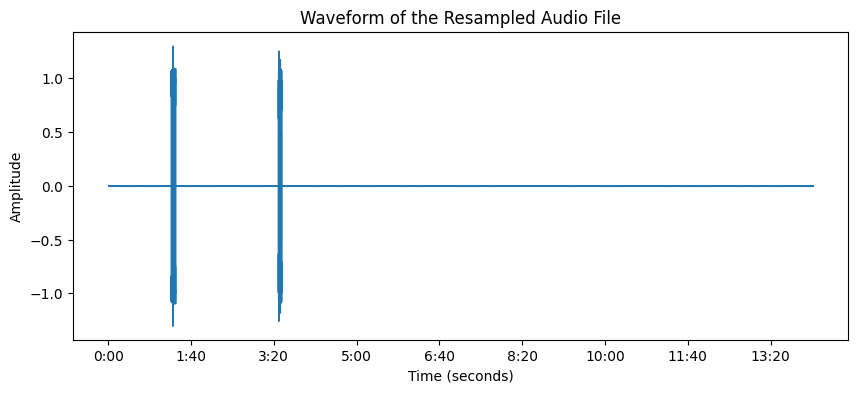

MFCC features saved to ../data/tartanaviation/processed/processed_audio_mfcc.csv


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:  11%|#         | 136M/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import required libraries
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

# Download and save the audio file locally
def download_audio(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Audio file downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"Failed to download audio file: {e}")

processed_audio_url = "https://raw.githubusercontent.com/GitAIwithMike/ATC-Models/main/data/tartanaviation/processed/processed_audio.wav"
local_audio_path = "processed_audio.wav"

download_audio(processed_audio_url, local_audio_path)

# Load processed audio file
def analyze_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=44100)
        resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        print(f"Loaded processed audio file.")
        print(f"Original Sample Rate: {sr}")
        print(f"Resampled Sample Rate: 16000")
        print(f"Duration: {len(audio) / sr:.2f} seconds")

        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(resampled_audio, sr=16000)
        plt.title("Waveform of the Resampled Audio File")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()
    except Exception as e:
        print(f"Failed to load {audio_path}: {e}")

analyze_audio(local_audio_path)

# Extract MFCC features and save
mfcc_folder = "../data/tartanaviation/processed/"
os.makedirs(mfcc_folder, exist_ok=True)

def extract_mfcc(audio_path, output_folder):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)

        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.vstack([mfccs, mfccs_delta, mfccs_delta2])

        mfcc_df = pd.DataFrame(combined_mfccs.T)
        output_path = os.path.join(output_folder, "processed_audio_mfcc.csv")
        mfcc_df.to_csv(output_path, index=False)
        print(f"MFCC features saved to {output_path}")
    except Exception as e:
        print(f"Failed to extract MFCC from {audio_path}: {e}")

extract_mfcc(local_audio_path, mfcc_folder)

# Speech-to-text using Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

def transcribe_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return processor.batch_decode(predicted_ids)[0]
    except Exception as e:
        print(f"Failed to transcribe {audio_path}: {e}")
        return ""

transcription = transcribe_audio(local_audio_path)
print(f"Transcription: {transcription}")

# Intent classification
intent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
intent_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
intent_labels = ["clearance_request", "alert", "weather_request"]

def classify_intent(transcription):
    try:
        inputs = intent_tokenizer(transcription, return_tensors="pt", truncation=True, padding=True)
        outputs = intent_model(**inputs)
        return intent_labels[torch.argmax(outputs.logits, dim=-1).item()]
    except Exception as e:
        print(f"Failed to classify intent for transcription: {e}")
        return "unknown"

intent = classify_intent(transcription)
print(f"Detected Intent: {intent}")

# Suggest action based on intent
def suggest_action(intent, trajectory_data, weather_data):
    if intent == "clearance_request":
        return f"Clearance granted for {trajectory_data['flight_id']}."
    elif intent == "alert":
        return f"Notify authorities about restricted airspace violation by {trajectory_data['flight_id']}!"
    elif intent == "weather_request":
        return f"Weather update: Visibility {weather_data['visibility']}, Wind Speed {weather_data['wind_speed']}!"
    else:
        return "No action required."

trajectory_data = {"flight_id": "ABC123", "altitude": 30000, "heading": 180}
weather_data = {"location": "runway_22", "visibility": "5 miles", "wind_speed": "10 knots"}

action = suggest_action(intent, trajectory_data, weather_data)
print(f"Suggested Action: {action}")

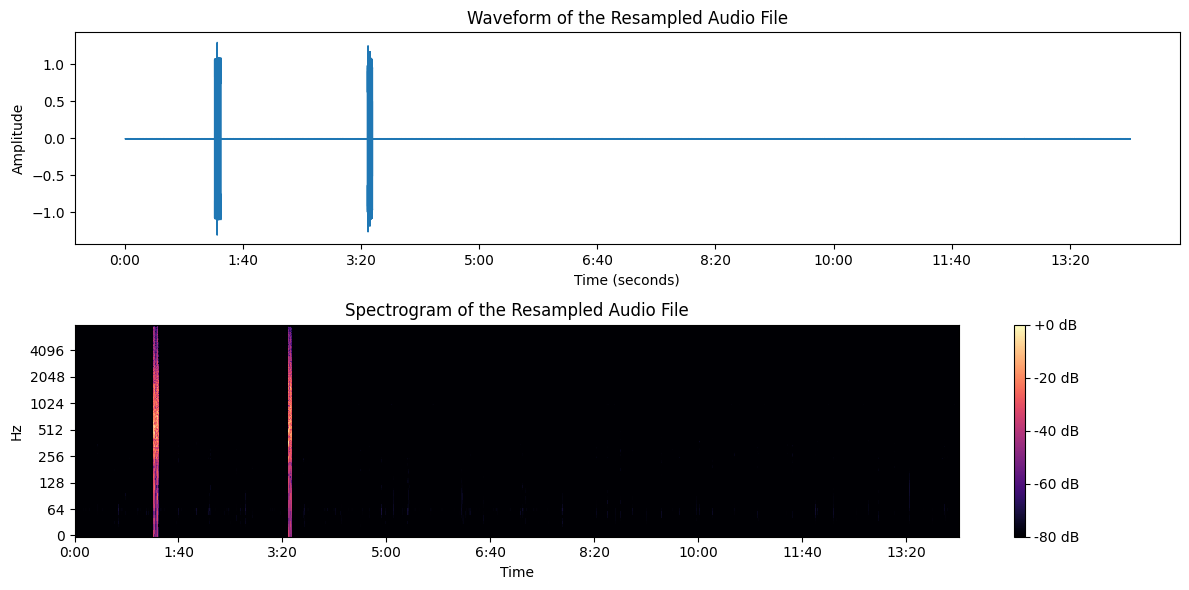

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import required libraries
import os
import logging
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to download and save the audio file locally
def download_audio(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            file.write(response.content)
        logging.info(f"Audio file downloaded and saved to: {save_path}")
    except Exception as e:
        logging.error(f"Failed to download audio file: {e}")

# Dynamic paths
data_folder = os.path.join(os.getcwd(), "data", "tartanaviation", "processed")
os.makedirs(data_folder, exist_ok=True)
local_audio_path = os.path.join(data_folder, "processed_audio.wav")

# URL of the processed audio file
processed_audio_url = "https://raw.githubusercontent.com/GitAIwithMike/ATC-Models/main/data/tartanaviation/processed/processed_audio.wav"
download_audio(processed_audio_url, local_audio_path)

# Function to analyze the audio
def analyze_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=44100)
        resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        logging.info(f"Loaded processed audio file.")
        logging.info(f"Original Sample Rate: {sr}")
        logging.info(f"Resampled Sample Rate: 16000")
        logging.info(f"Duration: {len(audio) / sr:.2f} seconds")

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(resampled_audio, sr=16000)
        plt.title("Waveform of the Resampled Audio File")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")

        plt.subplot(2, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(resampled_audio)), ref=np.max)
        librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='log')
        plt.title("Spectrogram of the Resampled Audio File")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Failed to analyze {audio_path}: {e}")

analyze_audio(local_audio_path)

# Function to extract MFCC features
def extract_mfcc(audio_path, output_folder):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.vstack([mfccs, mfccs_delta, mfccs_delta2])

        mfcc_df = pd.DataFrame(combined_mfccs.T)
        output_path = os.path.join(output_folder, "processed_audio_mfcc.csv")
        mfcc_df.to_csv(output_path, index=False)
        logging.info(f"MFCC features saved to {output_path}")
    except Exception as e:
        logging.error(f"Failed to extract MFCC from {audio_path}: {e}")

extract_mfcc(local_audio_path, data_folder)

# Load Wav2Vec2 for speech-to-text
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Function to transcribe audio
def transcribe_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return processor.batch_decode(predicted_ids)[0]
    except Exception as e:
        logging.error(f"Failed to transcribe {audio_path}: {e}")
        return ""

transcription = transcribe_audio(local_audio_path)
logging.info(f"Transcription: {transcription}")

# Intent classification using BERT
intent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
intent_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
intent_labels = ["clearance_request", "alert", "weather_request"]

# Function to classify intent
def classify_intent(transcription):
    try:
        inputs = intent_tokenizer(transcription, return_tensors="pt", truncation=True, padding=True)
        outputs = intent_model(**inputs)
        return intent_labels[torch.argmax(outputs.logits, dim=-1).item()]
    except Exception as e:
        logging.error(f"Failed to classify intent for transcription: {e}")
        return "unknown"

intent = classify_intent(transcription)
logging.info(f"Detected Intent: {intent}")

# Suggest action based on intent
def suggest_action(intent, trajectory_data, weather_data):
    if intent == "clearance_request":
        return f"Clearance granted for {trajectory_data['flight_id']}."
    elif intent == "alert":
        return f"Notify authorities about restricted airspace violation by {trajectory_data['flight_id']}!"
    elif intent == "weather_request":
        return f"Weather update: Visibility {weather_data['visibility']}, Wind Speed {weather_data['wind_speed']}!"
    else:
        return "No action required."

trajectory_data = {"flight_id": "ABC123", "altitude": 30000, "heading": 180}
weather_data = {"location": "runway_22", "visibility": "5 miles", "wind_speed": "10 knots"}

action = suggest_action(intent, trajectory_data, weather_data)
logging.info(f"Suggested Action: {action}")


           0    1    2    3    4    5    6    7    8    9  ...   29   30   31  \
0 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4 -449.68054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

    32   33   34   35   36   37   38  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 39 columns]
                  0             1             2             3             4  \
count  26589.000000  26589.000000  26589.000000  26589.000000  26589.000000   
mean    -443.603737      1.410459     -0.580327     -0.106319     -0.141574   
std       55.877677

In [8]:
pip install transformers torchaudio librosa


In [9]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torchaudio


In [10]:
# Load the pre-trained Wav2Vec2 model and processor from Hugging Face
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Load the processed audio file
def load_audio(audio_path):
    # Use torchaudio to load the audio, which handles many formats like WAV, MP3, etc.
    waveform, sample_rate = torchaudio.load(audio_path)
    return waveform, sample_rate

# Resample audio to match model's expected sample rate (16kHz)
def preprocess_audio(waveform, sample_rate, target_sample_rate=16000):
    # Resample if necessary
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    return waveform

# Example usage
audio_path = '/content/ATC-Models/data/tartanaviation/processed/processed_audio.wav'
waveform, sample_rate = load_audio(audio_path)
waveform = preprocess_audio(waveform, sample_rate)


In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torchaudio

# Load the model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Load and preprocess audio
def load_audio(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    return waveform, sample_rate

# Resample audio to match model's expected sample rate (16kHz)
def preprocess_audio(waveform, sample_rate, target_sample_rate=16000):
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    # Ensure the tensor shape is (batch_size, num_samples)
    if waveform.dim() == 2:
        waveform = waveform.squeeze(0)  # Remove extra dimension if present
    return waveform

# Transcribe audio
def transcribe_audio(waveform):
    # Preprocess audio for Wav2Vec2
    inputs = processor(waveform, return_tensors="pt", sampling_rate=16000)

    # Perform inference with the model
    with torch.no_grad():
        logits = model(input_values=inputs.input_values).logits

    # Decode the output
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

# Path to the processed audio file
audio_path = '/content/ATC-Models/data/tartanaviation/processed/processed_audio.wav'

# Load and preprocess the audio
waveform, sample_rate = load_audio(audio_path)
waveform = preprocess_audio(waveform, sample_rate)

# Perform transcription
transcription = transcribe_audio(waveform)

# Print the transcription
print(f"Transcription: {transcription}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
